In [2]:
pip install neurokit2

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

                                              0.0/693.1 kB ? eta -:--:--
     ------------                           225.3/693.1 kB 4.6 MB/s eta 0:00:01
     ------------------------------------  686.1/693.1 kB 10.9 MB/s eta 0:00:01
     -------------------------------------- 693.1/693.1 kB 7.3 MB/s eta 0:00:00


In [4]:
pip install wfdb

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.

                                              0.0/160.0 kB ? eta -:--:--
     ------------------------------------   153.6/160.0 kB 4.6 MB/s eta 0:00:01
     -------------------------------------- 160.0/160.0 kB 3.2 MB/s eta 0:00:00
                                              0.0/1.0 MB ? eta -:--:--
     -------------------------                0.7/1.0 MB 20.8 MB/s eta 0:00:01
     ---------------------------------------- 1.0/1.0 MB 12.8 MB/s eta 0:00:00


In [11]:
# Importing packages
import os
import datetime
import wfdb
import pywt
import seaborn
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import pandas as pd

In [15]:
RECORDS = r'C:\Users\MATHAMGI NAIR\Downloads\mit-bih-arrhythmia-database-1.0.0\mit-bih-arrhythmia-database-1.0.0\RECORDS'
patient_ids = pd.read_csv(RECORDS, header=None).to_numpy().reshape(-1)
patient_ids

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234], dtype=int64)

In [17]:
#Extracting just 1 patient ECG signal and info
DATA_ROOT = r'C:\Users\MATHAMGI NAIR\Downloads\mit-bih-arrhythmia-database-1.0.0\mit-bih-arrhythmia-database-1.0.0'
lead0 = {}  # without this it shows lead0[100] is not defined
lead1 = {}
patient_id = 100
signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(100)))
lead0[100] = signals[:, 0]
lead1[100] = signals[:, 1]

<class 'numpy.ndarray'>
(650000,)
{'fs': 360, 'sig_len': 650000, 'n_sig': 2, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV'], 'sig_name': ['MLII', 'V5'], 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal']}


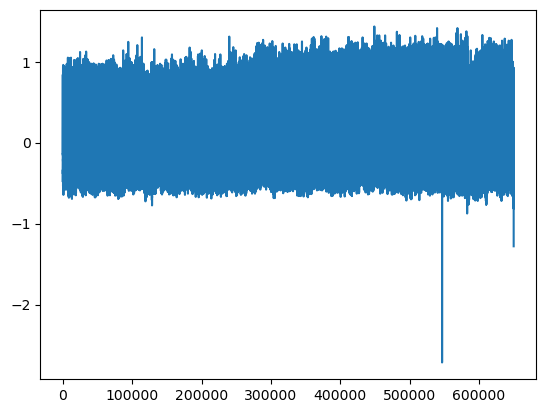

In [18]:
# Visualization of 1 patients signal and info
print(type(lead0[100]))
print(lead0[100].shape)
plt.plot(lead0[100])
print(info)

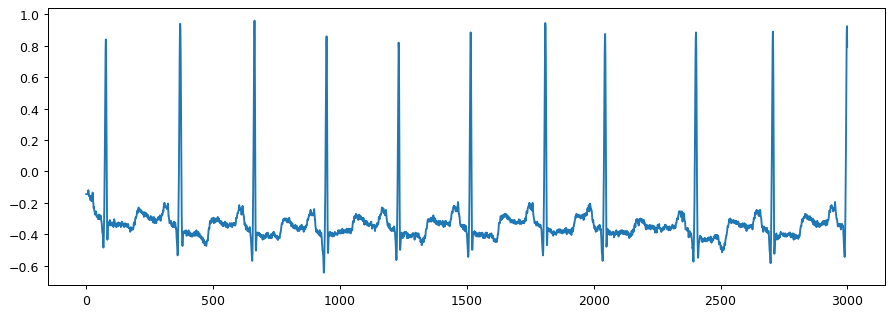

In [19]:
# ECG signal per second
a = lead0[100][0: 3000]
plt.figure(figsize=(12, 4), dpi=90)
plt.plot(a)

In [20]:
# Loading all patients ECG SIGNALs using for loop
def get_ecg_signals(patient_ids):
    lead0 = {}
    lead1 = {}
    for id_ in patient_ids:
        signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(id_)))
        lead0[id_] = signals[:, 0]
        lead1[id_] = signals[:, 1]
        print(f'Signal of patient {id_} extracted')
    return lead0, lead1

In [21]:
# Loading all patient ECG INFORMATION 
def get_ecg_info(patient_ids):
    _, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_ids)))
    resolution = 2**11  # Number of possible signal values we can have.
    info["resolution"] = 2**11
    return info

In [22]:
lead0, lead1 = get_ecg_signals(patient_ids)

Signal of patient 100 extracted
Signal of patient 101 extracted
Signal of patient 102 extracted
Signal of patient 103 extracted
Signal of patient 104 extracted
Signal of patient 105 extracted
Signal of patient 106 extracted
Signal of patient 107 extracted
Signal of patient 108 extracted
Signal of patient 109 extracted
Signal of patient 111 extracted
Signal of patient 112 extracted
Signal of patient 113 extracted
Signal of patient 114 extracted
Signal of patient 115 extracted
Signal of patient 116 extracted
Signal of patient 117 extracted
Signal of patient 118 extracted
Signal of patient 119 extracted
Signal of patient 121 extracted
Signal of patient 122 extracted
Signal of patient 123 extracted
Signal of patient 124 extracted
Signal of patient 200 extracted
Signal of patient 201 extracted
Signal of patient 202 extracted
Signal of patient 203 extracted
Signal of patient 205 extracted
Signal of patient 207 extracted
Signal of patient 208 extracted
Signal of patient 209 extracted
Signal o

Text(0, 0.5, 'Amplitude (mV)')

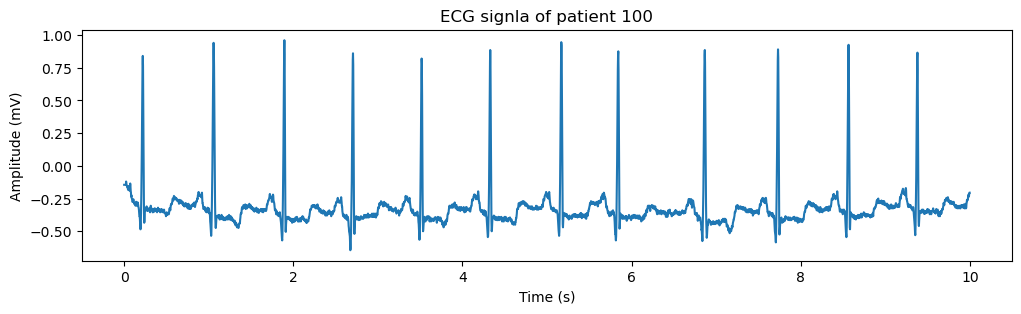

In [23]:
# Plot any patient signal from any time frame
patient_id = 100 # can change
starting_time = 0 # can change
ending_time = 10 # can change

# Scaling
starting_signal_point = starting_time*350
ending_signal_point = ending_time*350 # As sampling frequency is 350 Hz
x = np.arange(starting_time, ending_time, 1/350)
signal = lead0[patient_id][starting_signal_point: ending_signal_point]

plt.figure(figsize=(12, 3), dpi=100)
plt.plot(x, signal)
plt.title(f'ECG signla of patient {patient_id}')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')

In [25]:
# ECG info of any patient
ecg_info = get_ecg_info(patient_ids[0])
ecg_info

{'fs': 360,
 'sig_len': 650000,
 'n_sig': 2,
 'base_date': None,
 'base_time': None,
 'units': ['mV', 'mV'],
 'sig_name': ['MLII', 'V5'],
 'comments': ['69 M 1085 1629 x1', 'Aldomet, Inderal'],
 'resolution': 2048}

In [26]:
# User defined fucntion for DWT and reconstruction
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

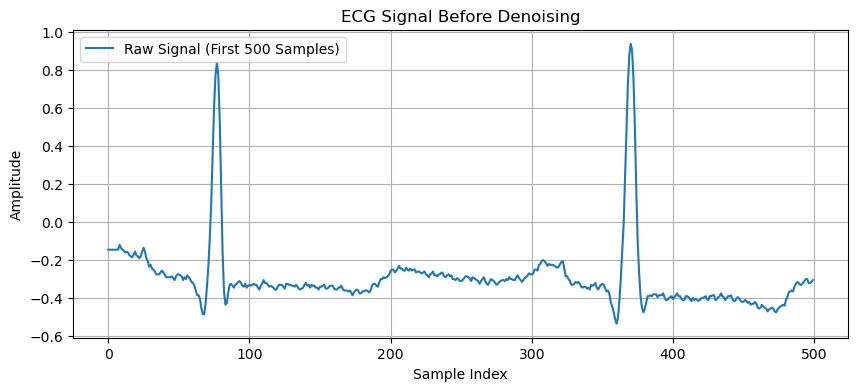

In [28]:
# Ploting a signal before denoising
project_path = r'C:\Users\MATHAMGI NAIR\Downloads\mit-bih-arrhythmia-database-1.0.0\mit-bih-arrhythmia-database-1.0.0\\'

# Read the record for patient 100, specifically the 'MLII' channel
record = wfdb.rdrecord(project_path + '100', channel_names=['MLII'])

# Extract the signal
data = record.p_signal.flatten()

# Plot the first 500 data points
plt.figure(figsize=(10, 4))
plt.plot(data[0:500], label='Raw Signal (First 500 Samples)')
plt.title('ECG Signal Before Denoising')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()
plt.show()

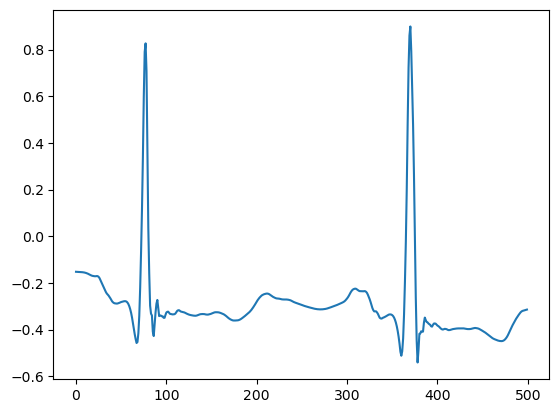

In [29]:
# Same signal after denoising
rdata = denoise(data=data)
plt.plot(rdata[0:500])

In [30]:
# For exmaple, we extract '100' recording annotation
annotation = wfdb.rdann(project_path + '100', 'atr')
Rlocation = annotation.sample
print(Rlocation)
Rclass = annotation.symbol
print(Rclass)

[    18     77    370 ... 649484 649734 649991]
['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'A', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', '

In [31]:
len(annotation.symbol)

2274

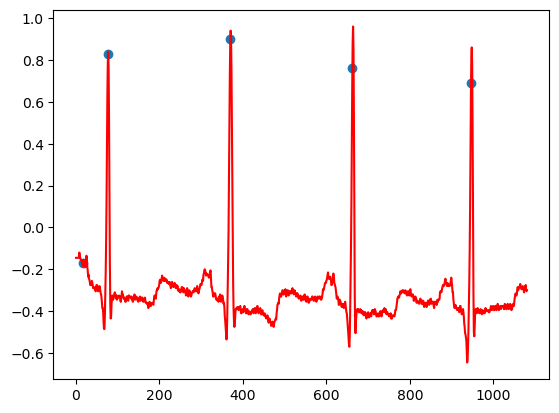

In [32]:
# R-peak ploting
x = np.arange(1, 1081)

n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])

plt.plot(x, data[0:1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

(300,)
(300,)
(300,)


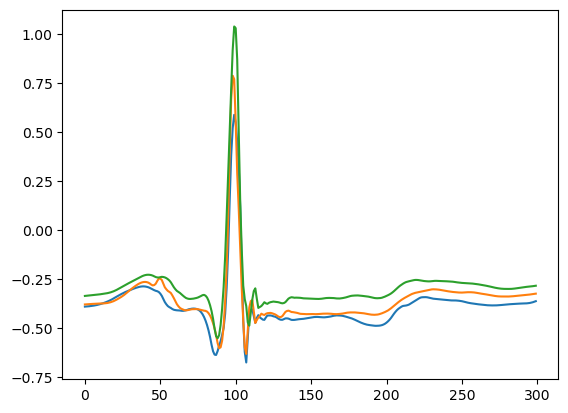

In [33]:
# Plotting 3 heartbeats
k = np.arange(100, 103)
for i in k:
  # print(i)
  # print(Rlocation[i] - 99, Rlocation[i] + 201)
  x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
  plt.plot(x_train)
  print(x_train.shape)
plt.show()

In [34]:
r_peak_xx = Rlocation[0], Rlocation[1], Rlocation[2], Rlocation[3]
r_peak_yy = rdata[Rlocation[0]], rdata[Rlocation[1]], rdata[Rlocation[2]], rdata[Rlocation[3]]

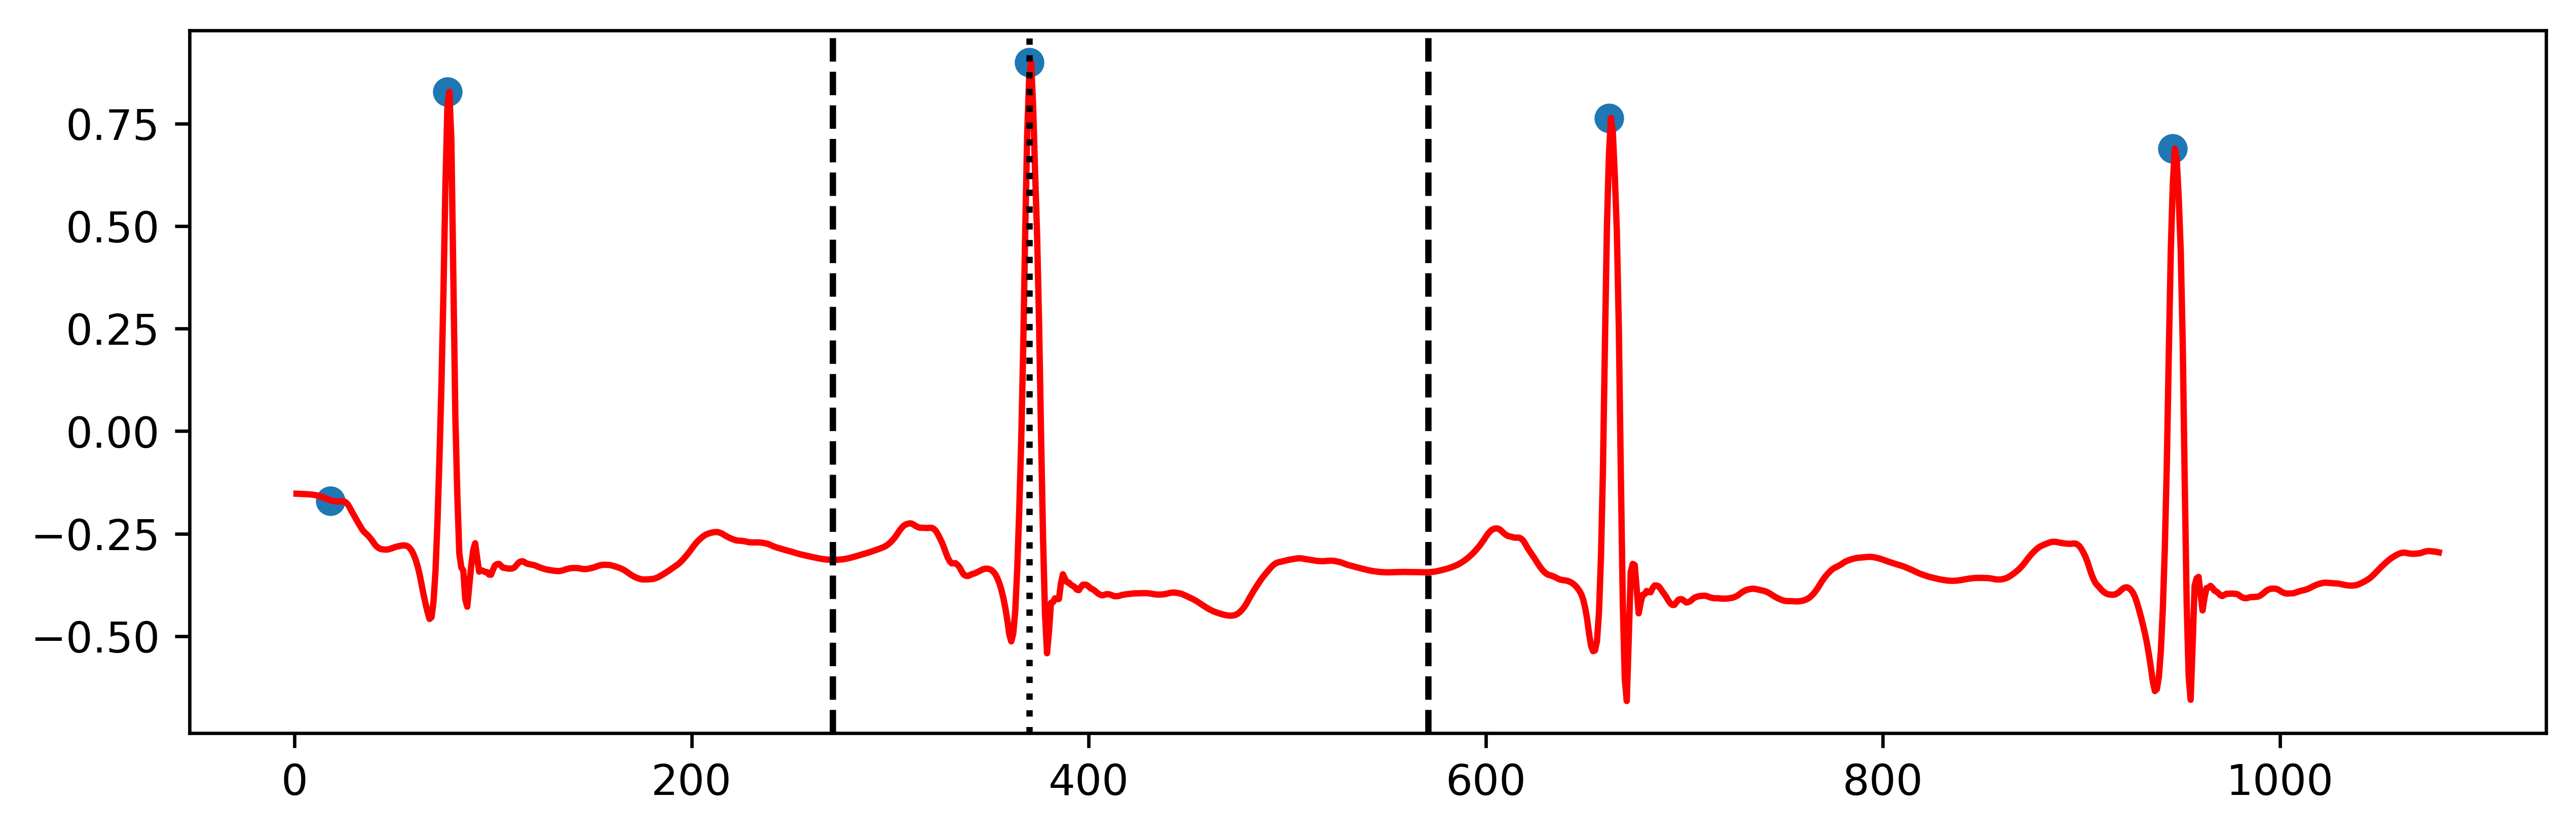

In [35]:
# Plotting R-peaks and segmentation lines
fig = plt.figure(figsize=(10,3), dpi=600)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)

# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':') 
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--') 
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--') 

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/ECG Arrhythmia trying/Heartbeat_Figures/Denoised and segmented ECG.png'

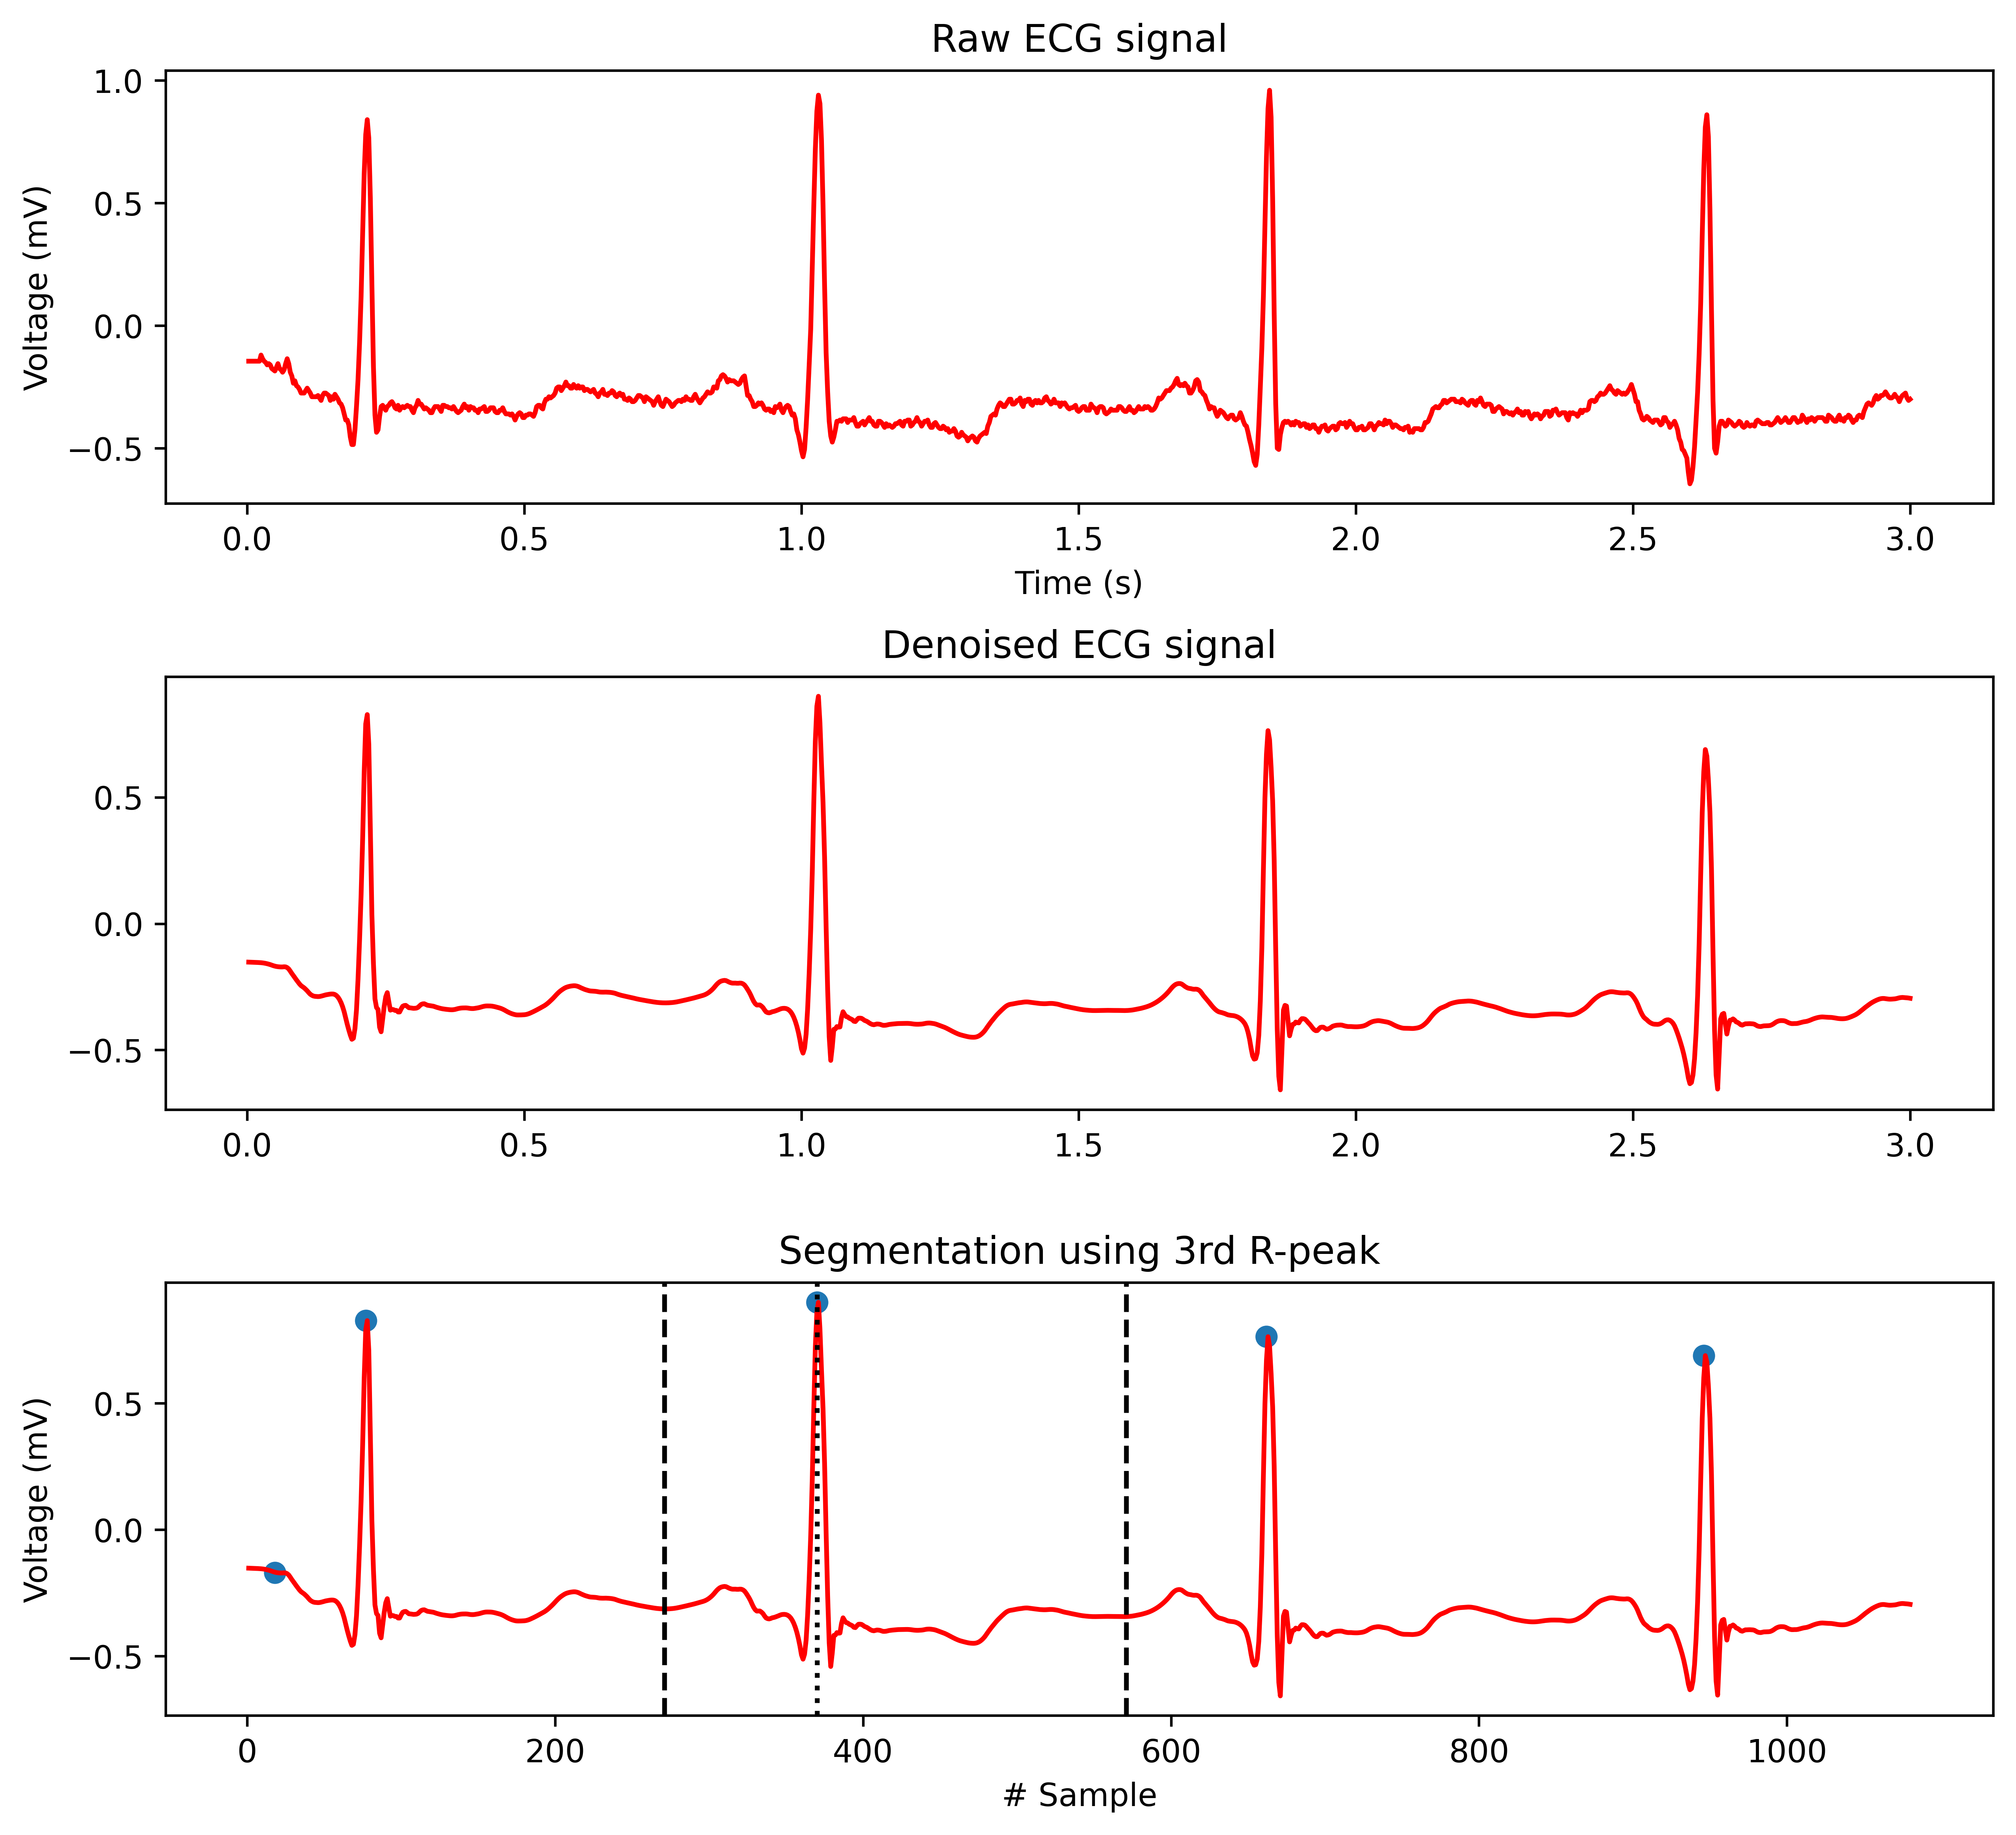

In [37]:
# Plot together raw, denoised and segmted signal
fig = plt.figure(figsize=(10,9), dpi=600)
x = np.arange(1, 1081)

# Define the directory to save the figure
figure_path = r'C:\Users\MATHAMGI NAIR\Documents\ECG_Heartbeat_Figures'

# Create the directory if it doesn't exist
os.makedirs(figure_path, exist_ok=True)

# Save the figure to the defined directory
fig.savefig(os.path.join(figure_path, 'Denoised_and_segmented_ECG.png'))

# Raw signal plotting
plt.subplot(3, 1, 1)
plt.plot(x/360, data[0:1080], color='red')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (mV)')
plt.title('Raw ECG signal')

# Denoised signal plotting
plt.subplot(3, 1, 2)
plt.plot(x/360, rdata[0:1080], color='red')
plt.title('Denoised ECG signal')

# Segmentation visualization using two border lines
plt.subplot(3, 1, 3)
n_peak =5
r_peak_x = []
r_peak_y = []
for i in range(0, n_peak):
  r_peak_x.append(Rlocation[i])
  r_peak_y.append(rdata[Rlocation[i]])
x = np.arange(1, 1081)
plt.plot(x, rdata[0: 1080], color='red')
plt.scatter(r_peak_x, r_peak_y)
# line plotting
plt.axvline(x = Rlocation[2], color = 'k', linestyle = ':') # 3rd r-peak
plt.axvline(x = Rlocation[2]-99, color = 'k', linestyle = '--') 
plt.axvline(x = Rlocation[2]+201, color = 'k', linestyle = '--') 

plt.xlabel('# Sample')
plt.ylabel('Voltage (mV)')
plt.title('Segmentation using 3rd R-peak')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

figure_path = '/content/gdrive/MyDrive/ECG Arrhythmia trying/Heartbeat_Figures/'
fig.savefig(figure_path+ 'Denoised and segmented ECG.png')

In [38]:
# Read ECG signals and corresponding label
def getDataSet(number, X_data, Y_data):
    
    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q'] 

    # Reading Channel names
    _, info = wfdb.io.rdsamp(osj(project_path, number))
    channels = info['sig_name']
    channel1, channel2 = channels[0], channels[1]
    print(channel1, channel2)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record = wfdb.rdrecord(project_path + number, channel_names=[channel1])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation = wfdb.rdann(project_path + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3  
    i = start
    j = len(annotation.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type = Rclass[i]
            lable = ecgClassSet.index(beat_type)  # when beat is like '+' or other it will go on except loop
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [39]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
                 '222', '223', '228', '230', '231', '232', '233', '234'] # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # dataset and its label set
    X = train_ds[:, :300]
    Y = train_ds[:, 300]
    return X, Y

In [40]:
# Input X and Output Y data loading
X, Y = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [42]:
from collections import Counter

# Counting the number of each type of heartbeats
Y_list = list(Y)  # Ensure Y is defined earlier in your code
heartbeat_counts = Counter(Y_list)
print(heartbeat_counts)

Counter({0.0: 74920, 1.0: 8063, 2.0: 7244, 9.0: 7123, 12.0: 7012, 5.0: 2540, 13.0: 982, 11.0: 802, 4.0: 229, 6.0: 150, 10.0: 106, 7.0: 83, 14.0: 33, 3.0: 16, 8.0: 2})


In [43]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121', 
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', 
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
                 '222', '223', '228', '230', '231', '232', '233', '234']  # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)
    return train_ds

In [44]:
# Load the whole dataset (109305,301). Each row indicate an ECG beat time series data upto 300 
# and 301 colum is its label among 15 difference level
train_ds = loadData()

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [45]:
Y = train_ds[:, 300]

In [46]:
# Here 15 class of ECG data are saved 
Y_list = list(Y)
Counter(Y_list)

Counter({0.0: 74920,
         2.0: 7244,
         12.0: 7012,
         9.0: 7123,
         1.0: 8063,
         11.0: 802,
         5.0: 2540,
         13.0: 982,
         4.0: 229,
         6.0: 150,
         7.0: 83,
         10.0: 106,
         14.0: 33,
         3.0: 16,
         8.0: 2})

In [47]:
# 15 level to 5 level conversion
Y_5class = np.copy(Y)

for i in range(Y.shape[0]):
  # print(i)
  if 0 <= Y[i] <= 4:
    Y_5class[i] = 0
  if 5 <= Y[i] <= 8:
    Y_5class[i] = 1
  if 9 <= Y[i] <= 10:
    Y_5class[i] = 2
  if Y[i] == 11:
    Y_5class[i] = 3
  if 12 <= Y[i] <= 14:
    Y_5class[i] = 4
print('changing done')

changing done


In [48]:
Y_5class_list = list(Y_5class)
Counter(Y_5class_list)

Counter({0.0: 90472, 4.0: 8027, 2.0: 7229, 3.0: 802, 1.0: 2775})

In [49]:
ecg_dataset = np.copy(train_ds)

In [50]:
# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_5class = LabelEncoder().fit_transform(Y_5class)

In [51]:
ecg_data = ecg_dataset[:, :300]
ecg_lable = Y_5class.reshape(-1, 1) # otherwise np.hstack will not work 

In [52]:
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data, ecg_lable))

In [53]:
# train test splitting
from sklearn.model_selection import train_test_split
ecg_data = ecg_dataset_5[:, :300]
ecg_label = ecg_dataset_5[:, 300]
x_train, x_test, y_train, y_test = train_test_split(ecg_data, ecg_label,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)

In [54]:
# reshaping for using hstack function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
train_data = np.hstack((x_train, y_train))
test_data = np.hstack((x_test, y_test))

In [55]:
#  converting dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

In [56]:
# saving the test data (in imbalanced condition)
file_name = project_path + 'test_data.pkl'
test_data.to_pickle(file_name)

0.0    72498
4.0     6342
2.0     5700
1.0     2262
3.0      642
Name: 300, dtype: int64


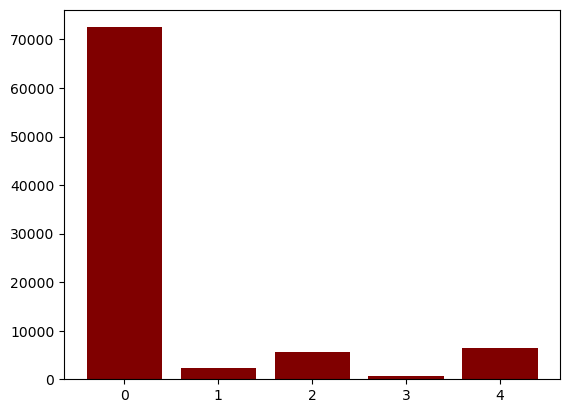

In [57]:
# Imblanced training data graph ploting 
class_data = train_data[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

In [58]:
# CLASS BALANCING
# extracting class 0 and 4 others class
train_data_0 = train_data.loc[(train_data[300] == 0)]
train_data_1234 = train_data.loc[(train_data[300] != 0)]

In [59]:
# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled=train_data_0.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled = train_data_0_resampled.to_numpy()

In [60]:
# 2. Class 1, 2, 3, 4: Use SMOTE to oversample upto 50000 data

# converting from df to np ndarray
train_data_1234_arr = train_data_1234.to_numpy()
X_4cl, y_4cl = train_data_1234_arr[:, :-1], train_data_1234_arr[:, -1]

from imblearn.over_sampling import SMOTE
# transform the dataset
strategy = {1:50000, 2:50000, 3:50000, 4:50000}
oversample = SMOTE(sampling_strategy=strategy)
X, y = oversample.fit_resample(X_4cl, y_4cl)

y = y.reshape(-1, 1)
train_data_1234_resampled = np.hstack((X, y))

C:\ProgramData\anaconda3\Lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (50000) in class 1 will be larger than the number of samples in the majority class (class #4.0 -> 6342)
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (50000) in class 2 will be larger than the number of samples in the majority class (class #4.0 -> 6342)
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (50000) in class 3 will be larger than the number of samples in the majority class (class #4.0 -> 6342)
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (50000) in class 4 will be larger than the number of samples in the majority class (class #4.0 -> 634

In [61]:
# Join the class 0 and 1234
train_data_resampled = np.vstack((train_data_0_resampled, train_data_1234_resampled))

# shuffle the data, needed for proper training
np.take(train_data_resampled,np.random.permutation(train_data_resampled.shape[0]),axis=0,out=train_data_resampled)

array([[ 7.31577613e-04,  3.39028290e-03,  6.62368753e-03, ...,
        -8.92767889e-02, -9.00059632e-02,  1.00000000e+00],
       [ 1.79017772e-01,  1.62604623e-01,  1.47569615e-01, ...,
         1.20689592e+00,  7.18004489e-01,  3.00000000e+00],
       [-2.29930220e-01, -2.29700217e-01, -2.28253461e-01, ...,
        -2.30283801e-01, -2.61026149e-01,  3.00000000e+00],
       ...,
       [-1.69462983e-01, -1.73457858e-01, -1.77975487e-01, ...,
        -2.19454933e-01, -2.20926942e-01,  4.00000000e+00],
       [-1.78790256e-01, -1.88044937e-01, -1.96554428e-01, ...,
        -7.44998836e-01, -7.50797820e-01,  3.00000000e+00],
       [-3.36536034e-01, -3.36820857e-01, -3.36991468e-01, ...,
        -2.33130859e-01, -2.34141178e-01,  0.00000000e+00]])

1.0    50000
3.0    50000
0.0    50000
4.0    50000
2.0    50000
Name: 300, dtype: int64


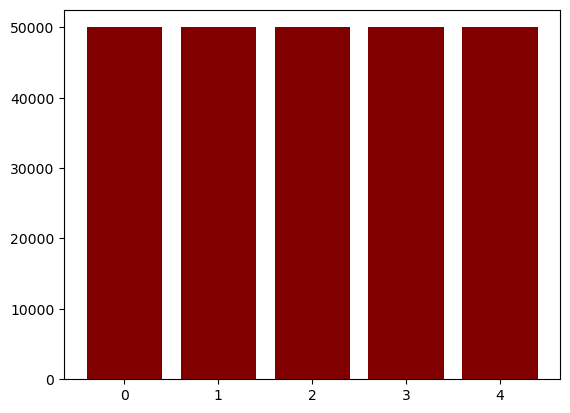

In [62]:
# blanced training data graph ploting 
train_data_r = pd.DataFrame(train_data_resampled)
class_data = train_data_r[300].value_counts()
print(class_data)
plt.bar(class_data.index, class_data.values, color ='maroon')
plt.show()

# save balanced training data
file_name = project_path + 'train_data_SMOTE.pkl'
train_data_r.to_pickle(file_name)

In [63]:
data_bal = np.array(class_data)
data_bal2 = data_bal.reshape(1, 5)

In [64]:
# MODEL BUILDING AND TRAINING
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib  # For saving the trained model


In [65]:
# Load the balanced training data
train_data_path = project_path + 'train_data_SMOTE.pkl'
test_data_path = project_path + 'test_data.pkl'

train_data_r = pd.read_pickle(train_data_path)
test_data = pd.read_pickle(test_data_path)


In [66]:
# Separate features (X) and labels (y)
X_train = train_data_r.iloc[:, :-1].to_numpy()
y_train = train_data_r.iloc[:, -1].to_numpy()

X_test = test_data.iloc[:, :-1].to_numpy()
y_test = test_data.iloc[:, -1].to_numpy()


In [67]:
# Initialize the model
rf_model = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    class_weight="balanced", 
    max_depth=10
)

# Fit the model
rf_model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

Accuracy: 0.94
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.96     17974
         1.0       0.37      0.80      0.51       513
         2.0       0.92      0.92      0.92      1529
         3.0       0.29      0.83      0.43       160
         4.0       0.98      0.96      0.97      1685

    accuracy                           0.94     21861
   macro avg       0.71      0.89      0.76     21861
weighted avg       0.96      0.94      0.95     21861

Confusion Matrix:
[[16873   683   112   279    27]
 [  101   410     1     1     0]
 [   61     9  1412    40     7]
 [   16     0    11   133     0]
 [   59     3     1     0  1622]]


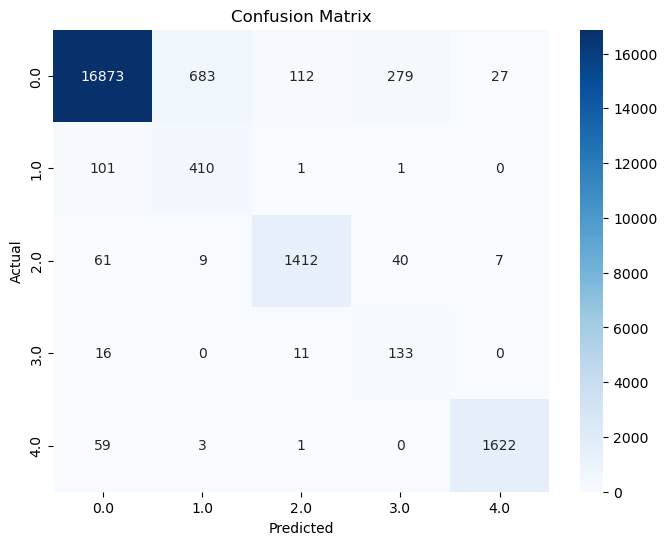

In [69]:
# Make predictions
import seaborn as sns
y_pred = rf_model.predict(X_test)

# Compute accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [70]:
# Save the trained model
model_path = project_path + 'random_forest_model.pkl'
joblib.dump(rf_model, model_path)
print(f"Model saved to {model_path}")


Model saved to C:\Users\MATHAMGI NAIR\Downloads\mit-bih-arrhythmia-database-1.0.0\mit-bih-arrhythmia-database-1.0.0\\random_forest_model.pkl


In [71]:
# Load the model for future use
loaded_model = joblib.load(model_path)

In [72]:
# Predict on a new sample (example)
new_sample = X_test[0].reshape(1, -1)
new_prediction = loaded_model.predict(new_sample)
print(f"Predicted class for the new sample: {new_prediction[0]}")

Predicted class for the new sample: 4.0
